# Walmart : Confidence Interval and CLT

## 1 Overview

### 1.1 Problem Statement

#### About Walmart

Walmart is an American multinational retail corporation that operates a chain of supercenters, discount departmental stores, and grocery stores from the United States.  
Walmart has more than 100 million customers worldwide.

#### Business Problem

The Management team at Walmart Inc. wants to analyze the customer purchase behavior (specifically, purchase amount) against the customer’s gender and the various other factors to help the business make better decisions. They want to understand if the spending habits differ between male and female customers: Do women spend more on Black Friday than men? (Assume 50 million customers are male and 50 million are female).

### 1.2 About Dataset

The company collected the transactional data of customers who purchased products from the Walmart Stores during Black Friday.

#### Features

The dataset has the following features:

- `User_ID`: User ID
- `Product_ID`: Product ID
- `Gender`: Sex of User
- `Age`: Age in bins
- `Occupation`: Occupation(Masked)
- `City_Category`: Category of the City (A,B,C)
- `Stay_In_Current_City_Years`: Number of years stay in current city
- `Marital_Status`: Marital Status
- `Product_Category`: Product Category (Masked)
- `Purchase`: Purchase Amount

#### Observations

1. All Personally Identifiable Information (PII) are masked in the dataset.
2. Dataset is missing purchase date.

### 1.3 Objective

Objective of this case study is to perform an Exploratory Data Analysis (EDA) on the dataset and attempt to:

1. Extract useful information from data using **descriptive statistics**.
2. Find out an interval within which the average spending of 50 million male and female customers.
3. Find out an interval within which the average spending of married vs Unmarried customers.
4. Find out an interval within which the average spending of customers of different age groups.

## 2 Setup

### 2.1 Libraries

#### Import Libraries

In [1]:
# Data manipulation libraries.
import numpy as np
import pandas as pd

# Data visualization libraries.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

NumPy version: 2.3.4
Pandas version: 2.3.3
Matplotlib version: 3.10.7
Seaborn version: 0.13.2


#### Configure Libraries

In [2]:
# Configure NumPy.
np.random.seed(42)

# Configure Seaborn.
sns.set_style("whitegrid")
sns.set_palette("deep")

#### Helper functions

In [3]:
def top_n_percent(series, n=5):
    """
    Function to display top `n` rows in given series.
    """
    top_5_rows = (
        series.value_counts(normalize=True)
        .multiply(100)
        .round(2)
        .reset_index(name="Percentage")
        .head(n)
    )
    display(top_5_rows)

### 2.2 Dataset

#### Import DataSet

In [4]:
wm_df = pd.read_csv("data/walmart_data.csv")  # Walmart DataFrame

row_count, col_count = wm_df.shape

display(wm_df.head(3))
print(f"Dataset has {row_count} rows and {col_count} columns.")

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422


Dataset has 550068 rows and 10 columns.


##### Observations

Dataset contains details of ~500K (550,068) purchases made by customers.

### 2.3 Data Profiling

In [5]:
wm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


#### 1 Feature types

##### Categorical Features

1. Gender
1. Marital_Status
1. Product_Category

##### Ordinal Features

1. Age
1. Occupation
1. City_Category
1. Stay_In_Current_City_Years

##### Numerical Features

1. Purchase

#### 2 Cardinality

In [6]:
wm_df.nunique().sort_values(ascending=False)

Purchase                      18105
User_ID                        5891
Product_ID                     3631
Occupation                       21
Product_Category                 20
Age                               7
Stay_In_Current_City_Years        5
City_Category                     3
Gender                            2
Marital_Status                    2
dtype: int64

##### Observations

Dataset contains details of 3,631 unique products purchased by 5,891 unique customers across 20 different product category.

#### 3 Correlation Matrix

In [7]:
corr = wm_df.corr(numeric_only=True)

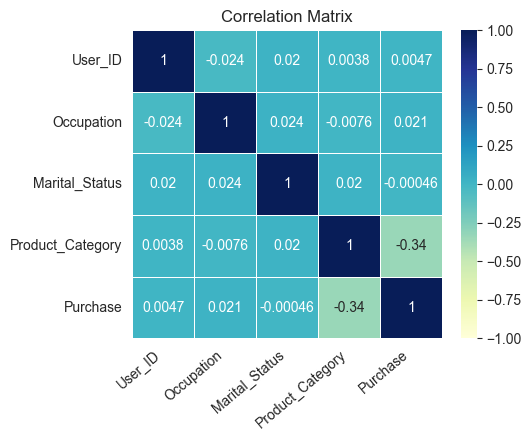

In [8]:
plt.figure(figsize=(5, 4))
ax = sns.heatmap(corr, cmap="YlGnBu", linecolor="white", linewidth=0.5, vmin=-1, vmax=1, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Correlation Matrix")
plt.show()

##### Observations

There is high negative correlation of -0.34 between product category and purchase.

## 3 Data Wrangling

Under Data Wrangling lets perform these operations:

1. Data Validation
2. Transform Features
3. Handling Outliers

### 3.1 Data Validation

#### 1 Handling Missing Values

In [9]:
wm_df.isna().sum().reset_index(name="count")

,index,count
0,User_ID,0
1,Product_ID,0
2,Gender,0
3,Age,0
4,Occupation,0
5,City_Category,0
6,Stay_In_Current_City_Years,0
7,Marital_Status,0
8,Product_Category,0
9,Purchase,0


##### Observations

1. All the features have zero missing values.
2. Dataset does not contain any missing values.

#### 2 Duplicate check

Feature `Purchase` has very high cardinality, hence lets temporarily drop that feature and check for duplicates.

In [10]:
mask = wm_df.drop("Purchase", axis=1).duplicated()
wm_df[mask]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase


In [11]:
mask = wm_df.duplicated(subset=["User_ID", "Product_ID"])
wm_df[mask]

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase


##### Observations

1. Dataset contains unique purchases of products by users.
2. Dataset does not contain any duplicate values.

### 3.2 Rename Columns

Lets rename column `Stay_In_Current_City_Years` to shorter name `Stay_Years`.

In [12]:
wm_df.rename(columns={"Stay_In_Current_City_Years": "Stay_Years"}, inplace=True)

### 3.3 Handling Outliers

There is only one numerical feature: `Purchase`. Lets detect and delete outliers in `Purchase` feature.

#### Detect Outliers

In [13]:
# Get 25th percentile.
Q1 = wm_df["Purchase"].quantile(0.25)

# Get 75th percentile.
Q3 = wm_df["Purchase"].quantile(0.75)

# Get IQR value.
IQR = Q3 - Q1

# Calculate lower and upper bound.
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers using mask and return final result
mask = (wm_df["Purchase"] >= lower_bound) & (wm_df["Purchase"] <= upper_bound)

In [14]:
out_count, _ = wm_df[~mask].shape
out_per = (out_count / row_count) * 100
out_per = round(out_per, 2)

print(f"{out_count} rows are outliers.")
print(f"{out_per}% of data are outliers.")

2677 rows are outliers.
0.49% of data are outliers.


#### Delete Outliers

In [15]:
wm_df = wm_df[mask]

##### Observations

1. 2677 rows are outliers.
2. Since only 0.49% of dataset are outliers, there are deleted.

### 3.4 Decouple

Segregate User and Purchase information into Separate DataFrames for data analysis.

#### Unique Customers

In [16]:
usr_cols = [
    "User_ID",
    "Gender",
    "Age",
    "Occupation",
    "City_Category",
    "Stay_Years",
    "Marital_Status",
]

In [17]:
unq_users_df = (
    wm_df.groupby(usr_cols, observed=False)  # User column names.
    .agg(
        Product_Count=("Product_ID", "count"),
        Purchase_Sum=("Purchase", "sum"),
        Purchase_Avg=("Purchase", "mean"),
    )
    .reset_index()
)

display(unq_users_df.head(3))

unq_cust_row_count, _ = unq_users_df.shape
print("Total number of unique customers:", unq_cust_row_count)

,User_ID,Gender,Age,Occupation,City_Category,Stay_Years,Marital_Status,Product_Count,Purchase_Sum,Purchase_Avg
0,1000001,F,0-17,10,A,2,0,35,334093,9545.514286
1,1000002,M,55+,16,C,4+,0,77,810472,10525.610390
2,1000003,M,26-35,15,A,3,0,29,341635,11780.517241


Total number of unique customers: 5891


#### Unique Products

In [18]:
prd_cols = ["Product_ID", "Product_Category"]

In [19]:
unq_prod_df = (
    wm_df.groupby(prd_cols)  # Product column names.
    .agg(
        Purchase_Count=("User_ID", "count"),
        Min_Purchase=("Purchase", "min"),
        Max_Purchase=("Purchase", "max"),
        Avg_Purchase=("Purchase", "mean"),
    )
    .reset_index()
)

display(unq_prod_df.head(3))

unq_prod_row_count, _ = unq_prod_df.shape
print("Total number of unique products:", unq_prod_row_count)

,Product_ID,Product_Category,Purchase_Count,Min_Purchase,Max_Purchase,Avg_Purchase
0,P00000142,3,1152,2725,13716,11143.642361
1,P00000242,2,376,3214,16503,10551.851064
2,P00000342,5,244,1727,8896,5313.422131


Total number of unique products: 3631


## 4 Univariate Analysis

### 4.1 Categorical Features

#### Feature `Gender`

##### Gender Ratio

In [20]:
top_n_percent(unq_users_df["Gender"])

,Gender,Percentage
0,M,71.72
1,F,28.28


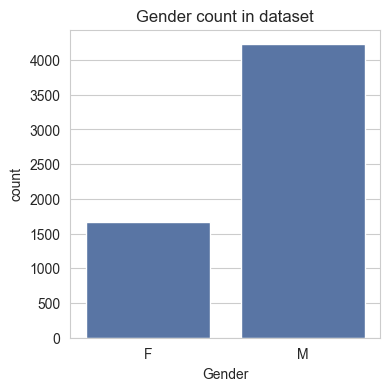

In [21]:
plt.figure(figsize=(4, 4))
sns.countplot(data=unq_users_df, x="Gender")
plt.title("Gender count in dataset")
plt.show()

##### Observations

1. 28% of customers are Females.
2. 72% of customers are Males.

#### Feature `Marital_Status`

##### Marital Status Ratio

In [22]:
top_n_percent(unq_users_df["Marital_Status"])

,Marital_Status,Percentage
0,0,58.0
1,1,42.0


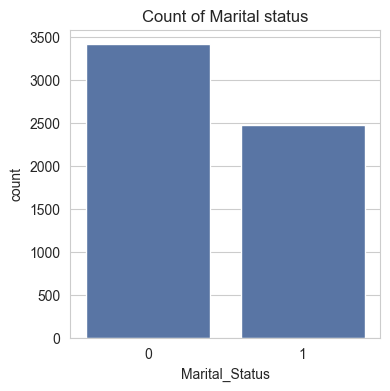

In [23]:
plt.figure(figsize=(4, 4))
sns.countplot(data=unq_users_df, x="Marital_Status")
plt.title("Count of Marital status")
plt.show()

##### Observations

1. 42% of customers are married.
2. 58% of customers are unmarried.

#### Feature `Age`

##### Top 5 Age groups

In [24]:
top_n_percent(unq_users_df["Age"], n=7)

,Age,Percentage
0,26-35,34.85
1,36-45,19.81
2,18-25,18.15
3,46-50,9.01
4,51-55,8.16
5,55+,6.31
6,0-17,3.70


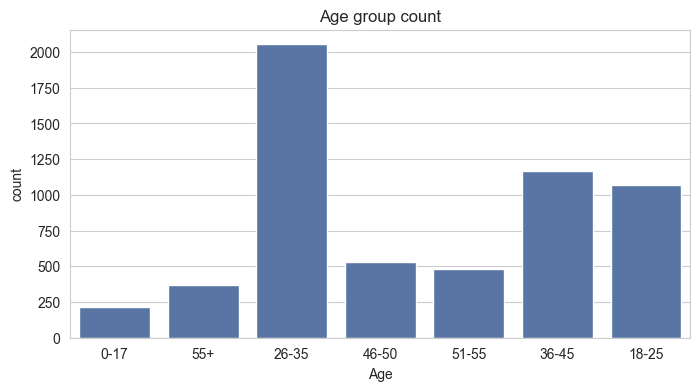

In [25]:
plt.figure(figsize=(8, 4))
sns.countplot(data=unq_users_df, x="Age")
plt.title("Age group count")
plt.show()

##### Observations

1. 18% of customers are between the age 18 and 25
1. 35% of customers are between the age 26 and 35
1. 20% of customers are between the age 36 and 45
1. 9% of customers are between the age 46 and 50
1. 8% of customers are between the age 51 and 55

#### Feature `Occupation`

##### Top 5 Occupations

In [26]:
top_n_percent(unq_users_df["Occupation"])

,Occupation,Percentage
0,4,12.56
1,0,11.68
2,7,11.36
3,1,8.78
4,17,8.33


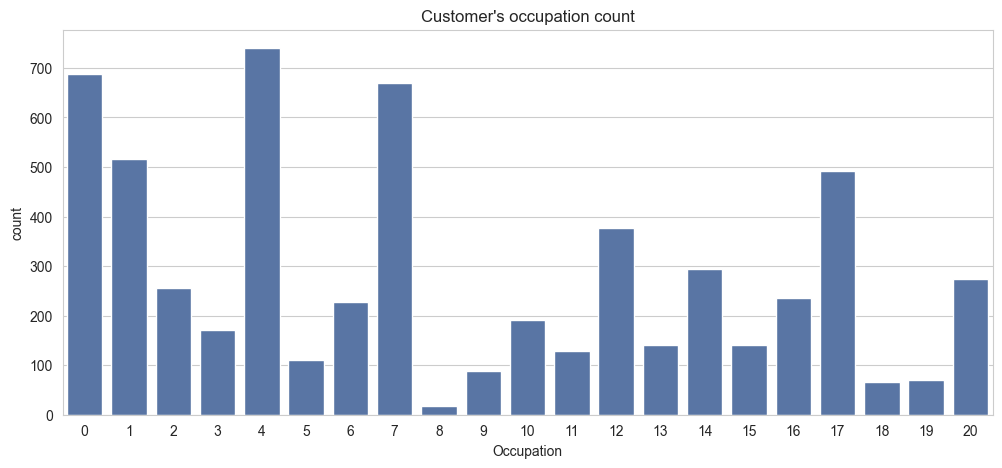

In [27]:
plt.figure(figsize=(12, 5))
sns.countplot(data=unq_users_df, x="Occupation")
plt.title("Customer's occupation count")
plt.show()

#### Feature `City_Category`

##### City Category Ratio

In [28]:
top_n_percent(unq_users_df["City_Category"])

,City_Category,Percentage
0,C,53.28
1,B,28.98
2,A,17.74


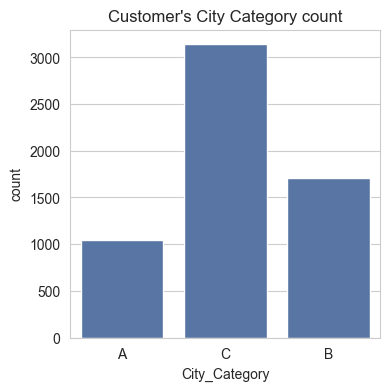

In [29]:
plt.figure(figsize=(4, 4))
sns.countplot(data=unq_users_df, x="City_Category")
plt.title("Customer's City Category count")
plt.show()

##### Observations

1. 53% of customers are from City Category C.
1. 29% of customers are from City Category B.
1. 18% of customers are from City Category A.

#### Feature `Stay_Years`

##### Residence years Ratio

In [30]:
top_n_percent(unq_users_df["Stay_Years"])

,Stay_Years,Percentage
0,1,35.41
1,2,19.44
2,3,16.62
3,4+,15.43
4,0,13.10


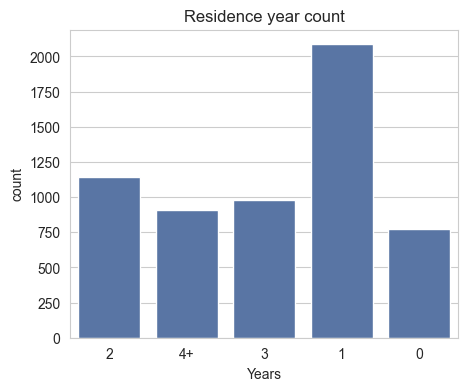

In [31]:
plt.figure(figsize=(5, 4))
sns.countplot(data=unq_users_df, x="Stay_Years")
plt.title("Residence year count")
plt.xlabel("Years")
plt.show()

#### Feature `Product_Category`

##### Top 5 Product categories

In [32]:
top_n_percent(unq_prod_df["Product_Category"])

,Product_Category,Percentage
0,8,28.84
1,5,26.63
2,1,13.58
3,11,7.00
4,2,4.19


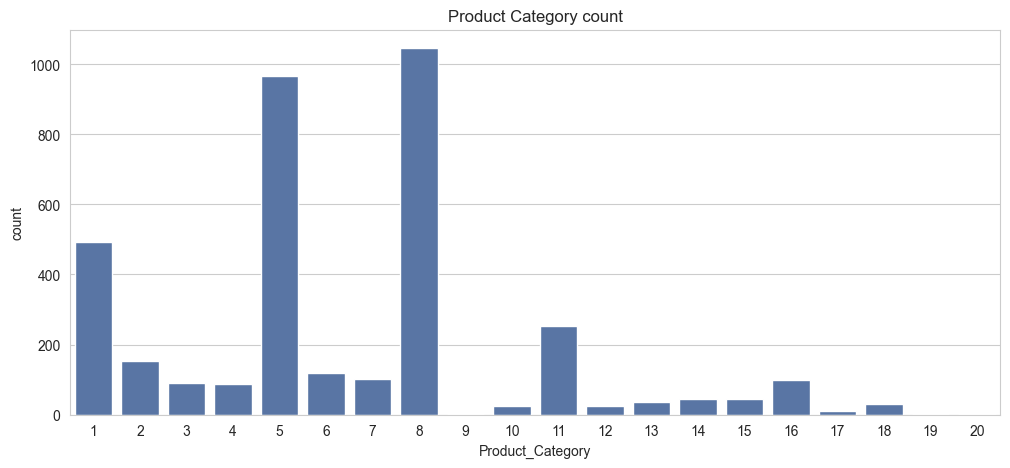

In [33]:
plt.figure(figsize=(12, 5))
sns.countplot(data=unq_prod_df, x="Product_Category")
plt.title("Product Category count")
plt.show()

##### Observations

1. Products in product category 1, 5 and 8 have high sales.
2. Products in product category 9, 10, 12, 13, 14, 17, 19 and 20 have some of the lowest sales.

### 4.2 Numerical Features

#### Feature `Purchase`

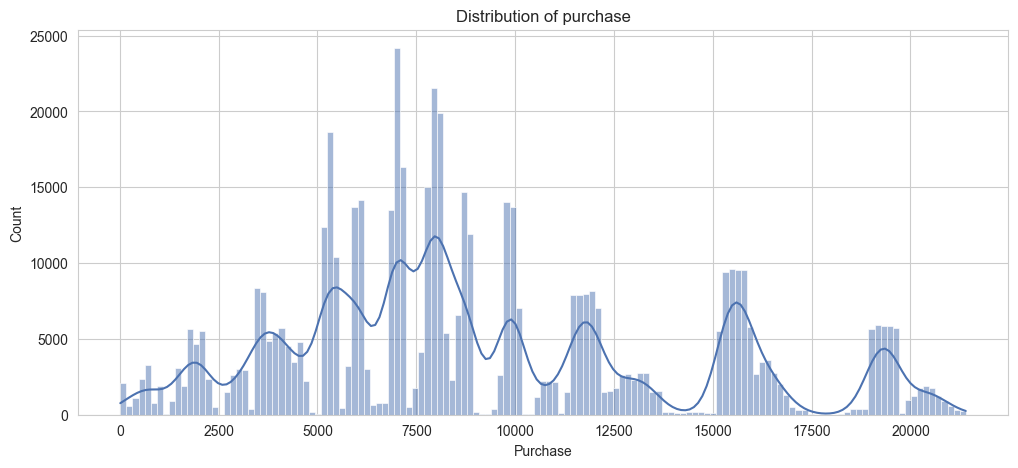

In [34]:
plt.figure(figsize=(12, 5))
sns.histplot(data=wm_df, x="Purchase", kde=True)
plt.title("Distribution of purchase")
plt.xticks(list(range(0, wm_df["Purchase"].max() + 1, 2500)))
plt.show()

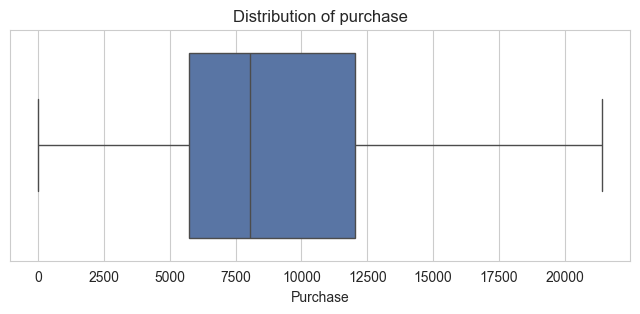

In [35]:
plt.figure(figsize=(8, 3))
sns.boxplot(data=wm_df, x="Purchase")
plt.title("Distribution of purchase")
plt.xticks(list(range(0, wm_df["Purchase"].max() + 1, 2500)))
plt.show()

##### Observations

Distribution of Purchase is highly skewed and has multiple modes.

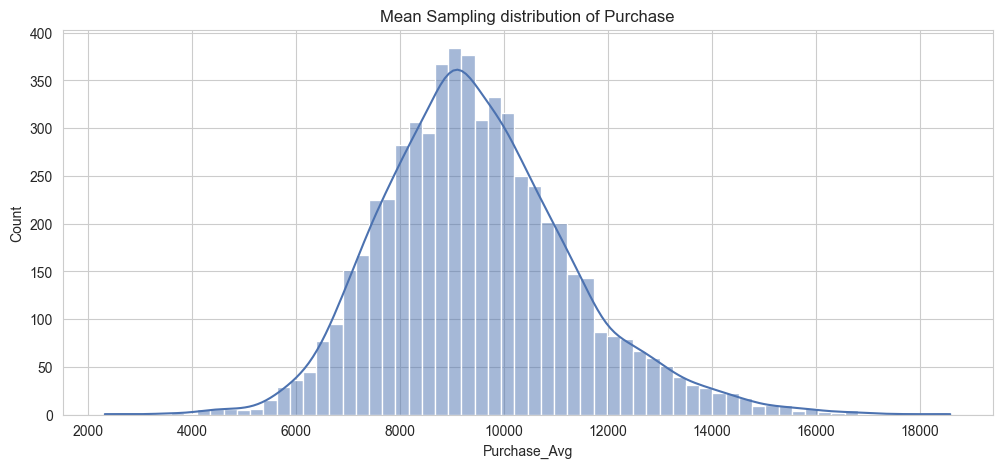

In [36]:
plt.figure(figsize=(12, 5))
sns.histplot(data=unq_users_df, x="Purchase_Avg", kde=True)
plt.title("Mean Sampling distribution of Purchase")
plt.show()

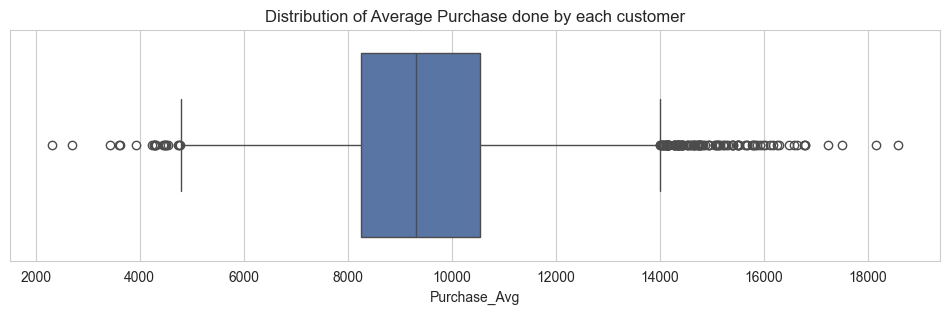

In [37]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=unq_users_df, x="Purchase_Avg")
plt.title("Distribution of Average Purchase done by each customer")
plt.show()

##### Observations

Mean of average purchases of all customers is normally distributed.

## 5 Bivariate Analysis

### 5.1 Categorical vs Categorical

#### Features `Age` vs `Gender`

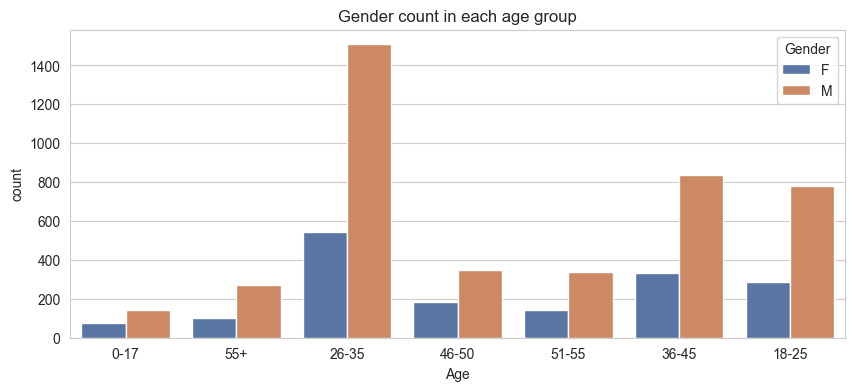

In [38]:
plt.figure(figsize=(10, 4))
sns.countplot(data=unq_users_df, x="Age", hue="Gender")
plt.title("Gender count in each age group")
plt.show()

##### Observations

In every age category male customers have higher purchase count compared to female customers.

#### Features `Age` vs `Product_Category`

In [39]:
pc_age_mx = pd.crosstab(index=wm_df["Product_Category"], columns=wm_df["Age"])

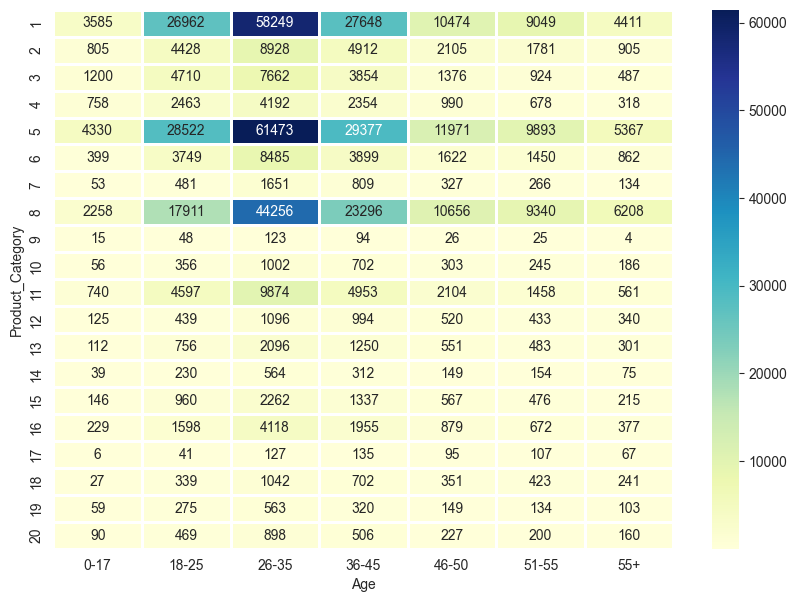

In [40]:
plt.figure(figsize=[10, 7])
sns.heatmap(pc_age_mx, cmap="YlGnBu", linecolor="white", linewidth=1, annot=True, fmt=".0f")
plt.show()

##### Observations

1. Products in product category 5 is most purchased among age group 26-35.
2. Other popular categories include 1, 8 and 11 among age group 26-35.
3. Products in product category 9, 10, 12, 14, 17, 18, 20 has some of the least purchases.

#### Features `Gender` vs `Product_Category`

In [41]:
pc_gender_mx = pd.crosstab(index=wm_df["Product_Category"], columns=wm_df["Gender"])

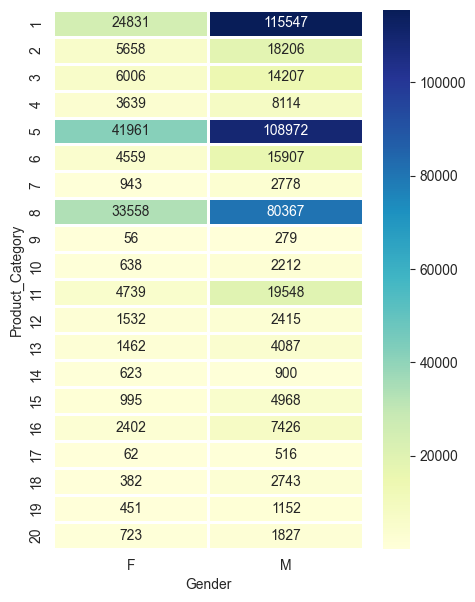

In [42]:
plt.figure(figsize=[5, 7])
sns.heatmap(pc_gender_mx, cmap="YlGnBu", linecolor="white", linewidth=1, annot=True, fmt=".0f")
plt.show()

##### Observations

1. Products in product category 1, 5 and 8 are highly purchased by both Male and Female customers.
2. Products in product category 11 is more popular among males.

#### Features `Purchase` vs `Gender`

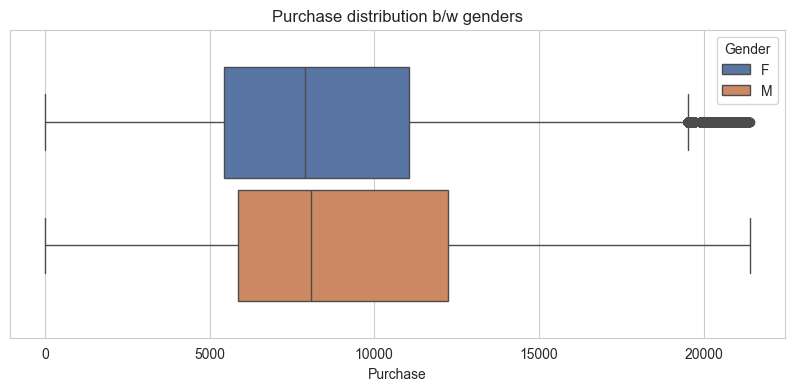

In [43]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=wm_df, x="Purchase", hue="Gender", gap=0.1)
plt.title("Purchase distribution b/w genders")
plt.show()

##### Observations

1. Median purchase amount of male and female customers are almost equal, even though the percentage of purchases done by females are less compared to Males.
2. The IQR of purchase amount of both male and female customers are almost same with males spending slightly higher compared to females.

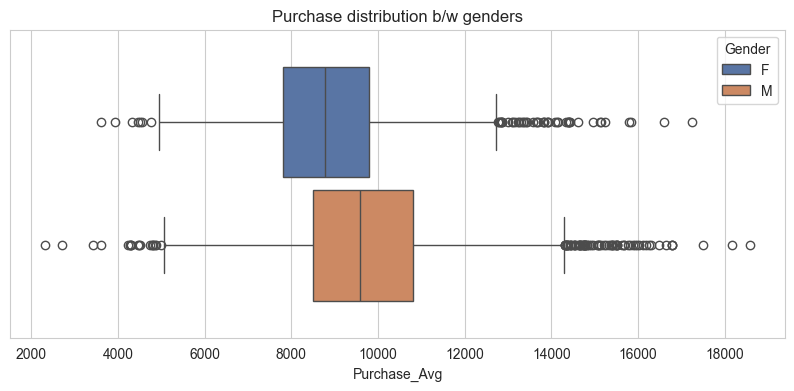

In [44]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=unq_users_df, x="Purchase_Avg", hue="Gender", gap=0.1)
plt.title("Purchase distribution b/w genders")
plt.show()

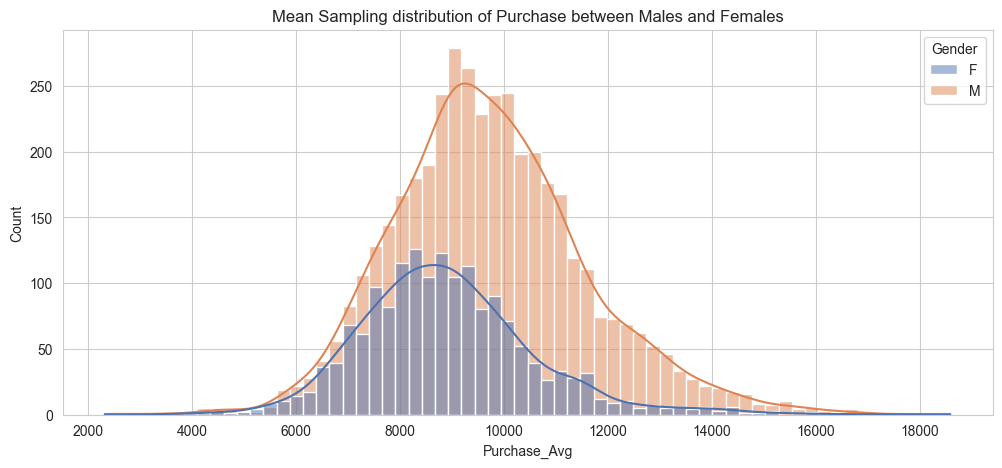

In [45]:
plt.figure(figsize=(12, 5))
sns.histplot(data=unq_users_df, x="Purchase_Avg", hue="Gender", kde=True)
plt.title("Mean Sampling distribution of Purchase between Males and Females")
plt.show()

### 5.2 Numerical vs Categorical

#### Features `Purchase` vs `Age`

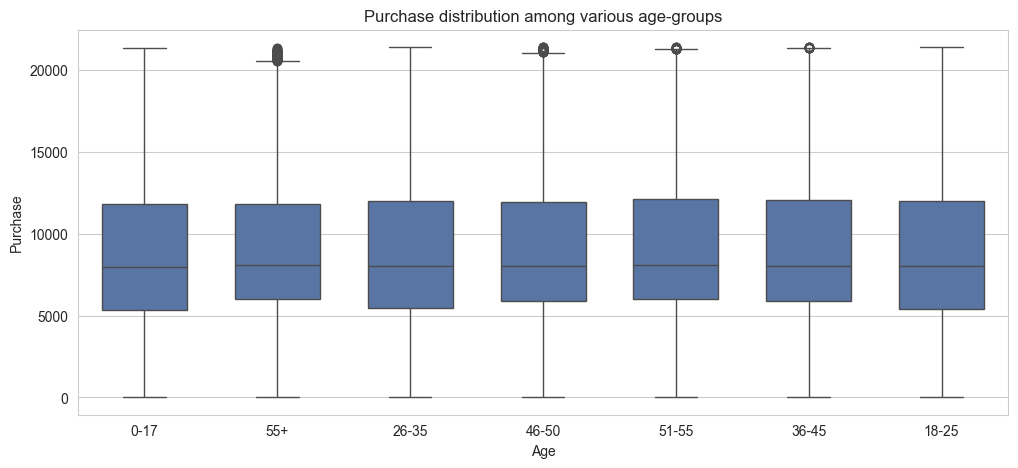

In [46]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=wm_df, y="Purchase", x="Age", gap=0.2)
plt.title("Purchase distribution among various age-groups")
plt.show()

##### Observations

Median purchase among all age groups are almost equal.

#### Features `Purchase` vs `Occupation`

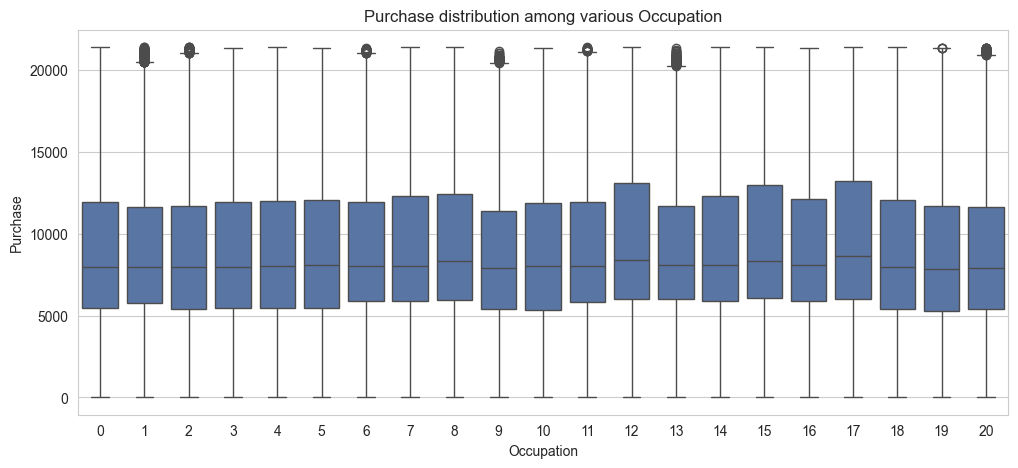

In [47]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=wm_df, x="Occupation", y="Purchase")
plt.title("Purchase distribution among various Occupation")
plt.show()

##### Observations

Median purchase by customers of all occupation types are nearly equal.

#### Features `Purchase` vs `Marital_Status`

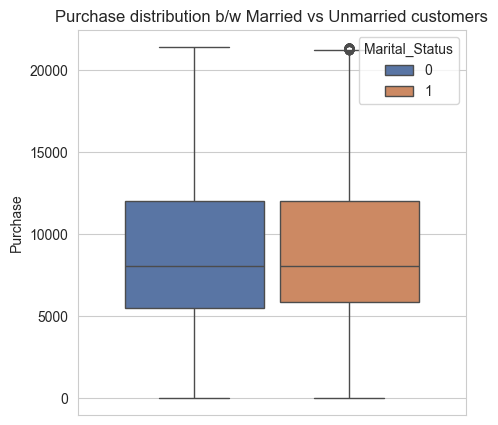

In [48]:
plt.figure(figsize=(5, 5))
sns.boxplot(data=wm_df, y="Purchase", hue="Marital_Status", gap=0.1)
plt.title("Purchase distribution b/w Married vs Unmarried customers")
plt.show()

##### Observations

Median purchase between married and unmarried customers are nearly equal.

#### Features `Purchase` vs `Stay_years`

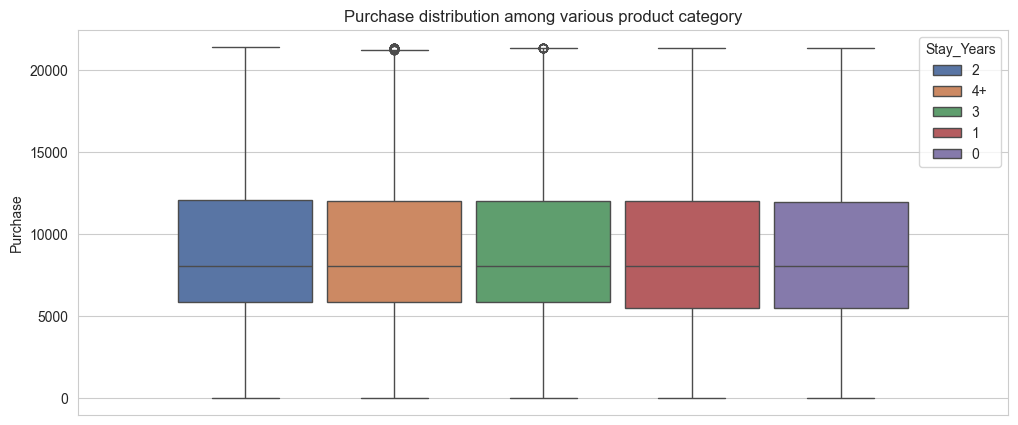

In [49]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=wm_df, hue="Stay_Years", y="Purchase", gap=0.1)
plt.title("Purchase distribution among various product category")
plt.show()

#### Features `Purchase` vs `Product_Category`

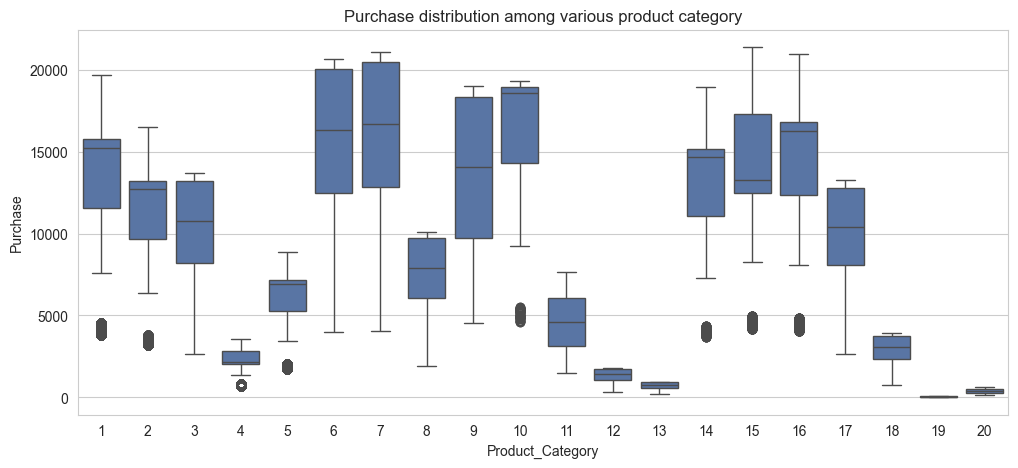

In [50]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=wm_df, x="Product_Category", y="Purchase")
plt.title("Purchase distribution among various product category")
plt.show()

##### Observations

1. Product category 4, 12 and 13 have low variance.
2. Product category 6, 7 and 9 have high variance.

## 6 Multivariate Analysis

### 6.1 Numerical vs Categorical vs Categorical

#### Features `Purchase` vs `Age` vs `Marital_Status`

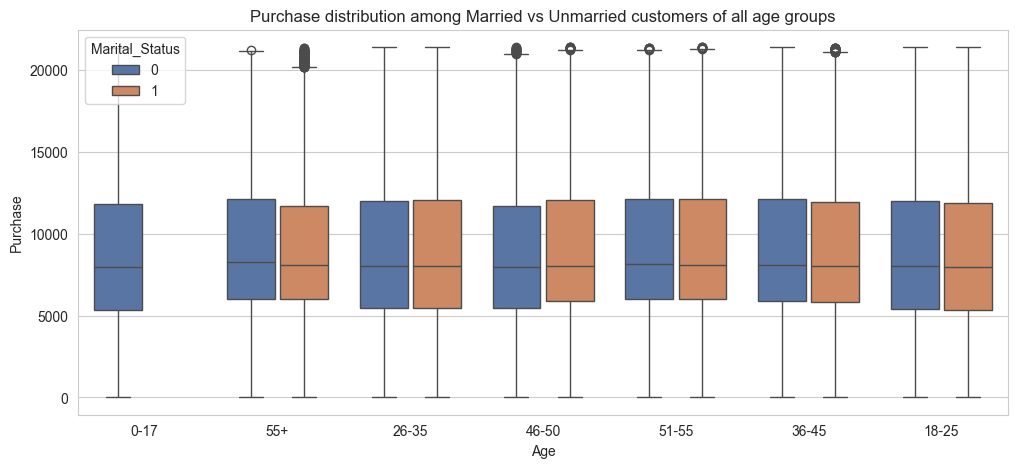

In [51]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=wm_df, y="Purchase", x="Age", hue="Marital_Status", gap=0.1)
plt.title("Purchase distribution among Married vs Unmarried customers of all age groups")
plt.show()

##### Observations

Median spending among Married vs Unmarried customers of all age groups are nearly same.

## 7 Descriptive Statistics

### 7.1 Measure of Central Tendency

#### Feature `Purchase`

In [52]:
wm_df["Purchase"].describe().round(2).to_frame().T

,count,mean,std,min,25%,50%,75%,max
Purchase,547391.0,9195.63,4938.87,12.0,5721.0,8038.0,12019.0,21399.0


1. Range is between [\\$12, \\$21,400]
2. Mean = \$9,195
3. Median = \$8,038
4. Standard deviation = \$4,939

#### Feature `Purchase_Avg`

Mean Sampling distribution of Purchase

In [53]:
unq_users_df.groupby("Gender")["Purchase_Avg"].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
F,1666.0,8897.34,1662.59,3599.73,7809.03,8780.02,9787.60,17246.44
M,4225.0,9725.28,1872.39,2318.73,8487.90,9580.89,10810.45,18577.89


In [54]:
unq_users_df["Purchase_Avg"].describe().round(2).to_frame().T

,count,mean,std,min,25%,50%,75%,max
Purchase_Avg,5891.0,9491.14,1853.28,2318.73,8246.66,9321.21,10548.42,18577.89


##### Observations

1. Male customers have mean purchase amount of 9725.28 with standard deviation of 1872.39
2. Female customers have mean purchase amount of 8897.34 with standard deviation of 1662.59

### 7.2 Conditional Probability

#### Features `Product_Category` and `Gender`

In [55]:
pc_gen_ct = (
    pd.crosstab(
        index=wm_df["Product_Category"],
        columns=wm_df["Gender"],
        normalize=True,
        margins=True,
        margins_name="Total",
    )
    .multiply(100)
    .round(2)
)
pc_gen_ct

Gender,F,M,Total
Product_Category,,,
1,4.54,21.11,25.64
2,1.03,3.33,4.36
3,1.10,2.60,3.69
4,0.66,1.48,2.15
5,7.67,19.91,27.57
6,0.83,2.91,3.74
7,0.17,0.51,0.68
8,6.13,14.68,20.81
9,0.01,0.05,0.06


##### Observations

1. 21% of products under product category 1 are purchased by Males.
1. 20% of products under product category 5 are purchased by Males.
1. 15% of products under product category 8 are purchased by Males.
1. 4.5% of products under product category 1 are purchased by Females.
1. 8% of products under product category 5 are purchased by Females.
1. 6% of products under product category 8 are purchased by Females.

#### Features `Product_Category` and `Age`

In [56]:
pc_age_ct = (
    pd.crosstab(
        index=wm_df["Product_Category"],
        columns=wm_df["Age"],
        normalize=True,
        margins=True,
        margins_name="Total",
    )
    .multiply(100)
    .round(2)
)
pc_age_ct

Age,0-17,18-25,26-35,36-45,46-50,51-55,55+,Total
Product_Category,,,,,,,,
1,0.65,4.93,10.64,5.05,1.91,1.65,0.81,25.64
2,0.15,0.81,1.63,0.90,0.38,0.33,0.17,4.36
3,0.22,0.86,1.40,0.70,0.25,0.17,0.09,3.69
4,0.14,0.45,0.77,0.43,0.18,0.12,0.06,2.15
5,0.79,5.21,11.23,5.37,2.19,1.81,0.98,27.57
6,0.07,0.68,1.55,0.71,0.30,0.26,0.16,3.74
7,0.01,0.09,0.30,0.15,0.06,0.05,0.02,0.68
8,0.41,3.27,8.08,4.26,1.95,1.71,1.13,20.81
9,0.00,0.01,0.02,0.02,0.00,0.00,0.00,0.06


##### Observations

1. Products in product category 1, 5 and 8 are most purchased among age group 26-35.
2. Products in product category 5 are most purchased among age group 36-45.

## 8 Inferential Statistics

### 8.1 Confidence Interval

Since the purchase distribution is highly skewed its better to calculate Confidence Interval using bootstrapping instead of Central Limit Theorem.

#### Bootstrap Sampling

In [57]:
def get_confidence_interval(
    sample,
    sample_size: int = 30,
    n_iterations: int = 1000,
    confidence_level=0.95,
) -> tuple[list[float], float, float]:
    """
    Function to compute the confidence interval using bootstrap resampling.
    """

    # Bootstrap resampling.
    boot_sample_means: list[float] = []

    for _ in range(n_iterations):
        boot_sample = np.random.choice(sample, size=sample_size, replace=True)
        boot_sample_means.append(np.mean(boot_sample).item())

    # Compute percentiles for confidence interval.
    alpha = 1.0 - confidence_level
    lp = alpha / 2 * 100
    up = (1 - alpha / 2) * 100

    # Compute confidence interval using Percentile technique.
    x1, x2 = np.percentile(boot_sample_means, [lp, up])

    return boot_sample_means, x1.round(2).item(), x2.round(2).item()

#### Plot Distributions

In [58]:
def plot_ci(dist_a, pm_a, x1_a, x2_a, a_label, dist_b, pm_b, x1_b, x2_b, b_label, sample_size):
    plt.figure(figsize=(12, 5))

    sns.kdeplot(dist_a, linewidth=1, color="red", label=f"(A) {a_label}")
    plt.axvline(x1_a, linestyle="--", color="r", label="x1 (A)")
    plt.axvline(pm_a, linestyle="--", color="r", label="Mean (A)", alpha=0.4)
    plt.axvline(x2_a, linestyle="--", color="r", label="x2 (A)")

    sns.kdeplot(dist_b, linewidth=1, color="blue", label=f"(B) {b_label}")
    plt.axvline(x1_b, linestyle="--", color="b", label="x1 (B)")
    plt.axvline(pm_b, linestyle="--", color="b", label="Mean (B)", alpha=0.4)
    plt.axvline(x2_b, linestyle="--", color="b", label="x2 (B)")

    plt.xlabel("Purchase")
    plt.title(f"Distribution of Sample means (Sample size = {sample_size})")

    plt.legend()
    plt.show()

In [59]:
def plot_multi_ci(dists, x_vals, labels, sample_size):
    plt.figure(figsize=(12, 5))

    colors = ["violet", "indigo", "blue", "green", "yellow", "orange", "red"]
    for i in range(len(dists)):
        sns.kdeplot(dists[i], linewidth=1, color=colors[i], label=labels[i])
        plt.axvline(x_vals[i][0], linestyle="--", color=colors[i], alpha=0.6)
        plt.axvline(x_vals[i][1], linestyle="--", color=colors[i], alpha=0.6)

    plt.xlabel("Age Group")
    plt.title(f"Distribution of Sample means (Sample size = {sample_size})")

    plt.legend()
    plt.show()

### 8.2 CI of `Purchase` for `Gender`

In [60]:
mask = wm_df["Gender"] == "F"
fem_purchases = wm_df[mask]["Purchase"].values

In [61]:
mask = wm_df["Gender"] == "M"
mal_purchases = wm_df[mask]["Purchase"].values

#### Full dataset

In [62]:
dist_a, x1_a, x2_a = get_confidence_interval(
    sample=fem_purchases,
    sample_size=len(fem_purchases),
    confidence_level=0.95,
)
x1_a, x2_a

(8645.31, 8694.29)

In [63]:
dist_b, x1_b, x2_b = get_confidence_interval(
    sample=mal_purchases,
    sample_size=len(mal_purchases),
    confidence_level=0.95,
)
x1_b, x2_b

(9353.06, 9383.59)

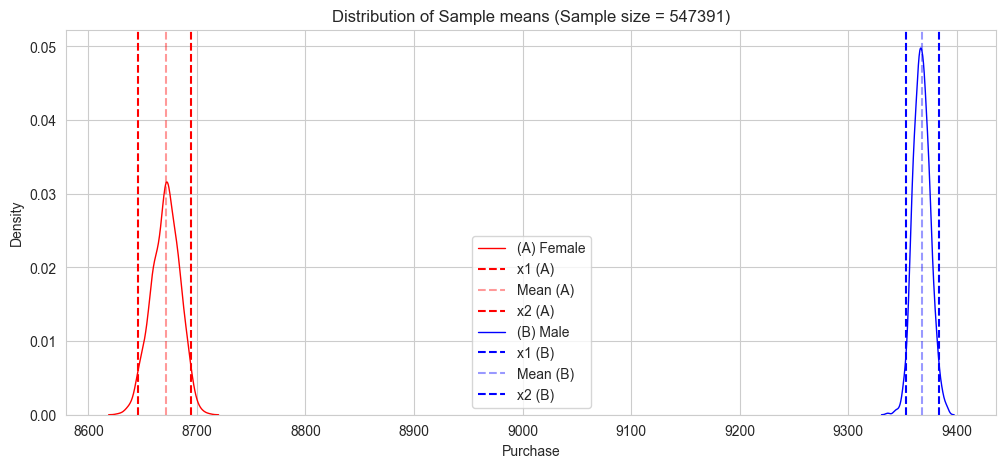

In [64]:
pm_a = np.mean(fem_purchases)
pm_b = np.mean(mal_purchases)
plot_ci(dist_a, pm_a, x1_a, x2_a, "Female", dist_b, pm_b, x1_b, x2_b, "Male", len(wm_df))

#### Sample Size 300

In [65]:
dist_a, x1_a, x2_a = get_confidence_interval(
    sample=fem_purchases,
    sample_size=300,
    confidence_level=0.95,
)
x1_a, x2_a

(8158.05, 9184.26)

In [66]:
dist_b, x1_b, x2_b = get_confidence_interval(
    sample=mal_purchases,
    sample_size=300,
    confidence_level=0.95,
)
x1_b, x2_b

(8801.88, 9922.81)

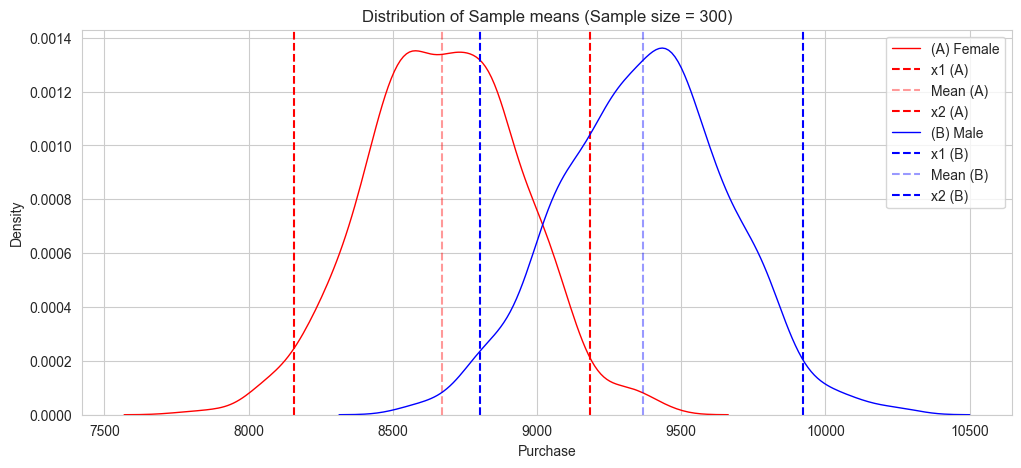

In [67]:
pm_a = np.mean(fem_purchases)
pm_b = np.mean(mal_purchases)
plot_ci(dist_a, pm_a, x1_a, x2_a, "Female", dist_b, pm_b, x1_b, x2_b, "Male", 300)

#### Sample Size 3,000

In [68]:
dist_a, x1_a, x2_a = get_confidence_interval(
    sample=fem_purchases,
    sample_size=3000,
    confidence_level=0.95,
)
x1_a, x2_a

(8514.47, 8823.19)

In [69]:
dist_b, x1_b, x2_b = get_confidence_interval(
    sample=mal_purchases,
    sample_size=3000,
    confidence_level=0.95,
)
x1_b, x2_b

(9181.39, 9554.68)

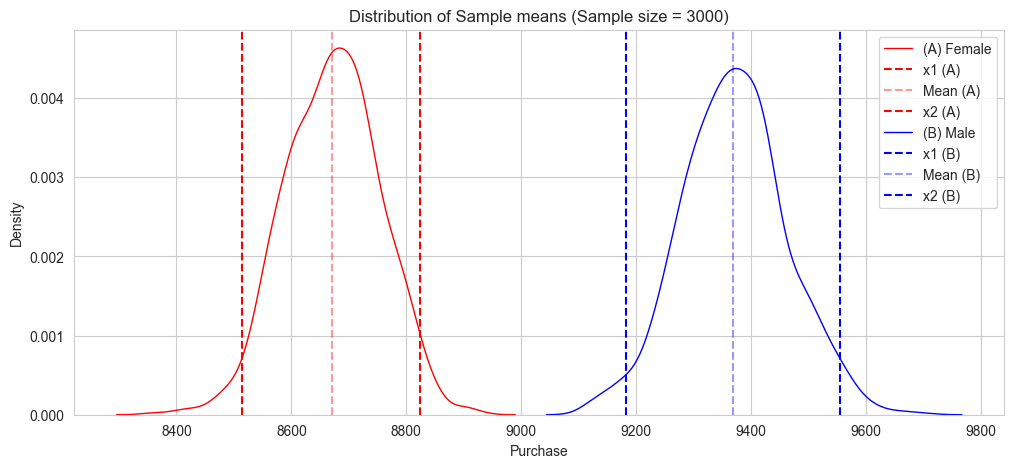

In [70]:
pm_a = np.mean(fem_purchases)
pm_b = np.mean(mal_purchases)
plot_ci(dist_a, pm_a, x1_a, x2_a, "Female", dist_b, pm_b, x1_b, x2_b, "Male", 3000)

#### Sample Size 30,000

In [71]:
dist_a, x1_a, x2_a = get_confidence_interval(
    sample=fem_purchases,
    sample_size=30_000,
    confidence_level=0.95,
)
x1_a, x2_a

(8620.39, 8724.52)

In [72]:
dist_b, x1_b, x2_b = get_confidence_interval(
    sample=mal_purchases,
    sample_size=30_000,
    confidence_level=0.95,
)
x1_b, x2_b

(9309.19, 9425.88)

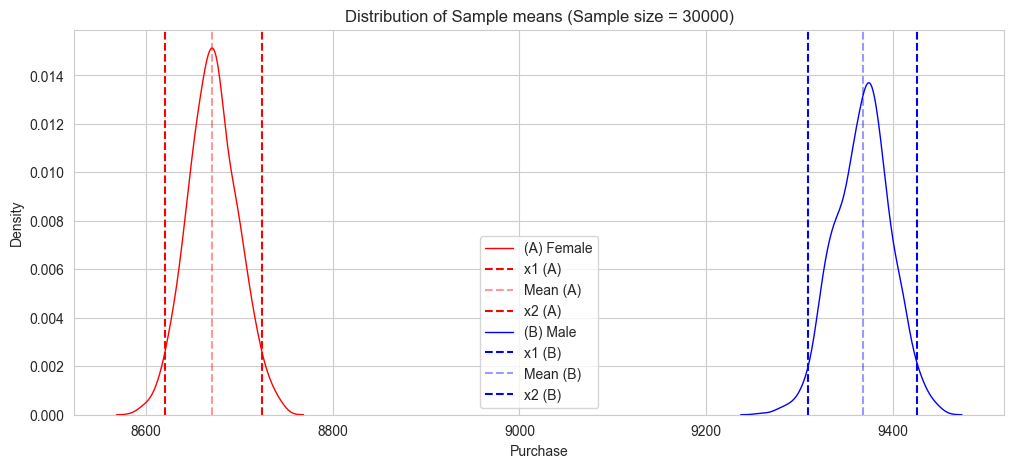

In [73]:
pm_a = np.mean(fem_purchases)
pm_b = np.mean(mal_purchases)
plot_ci(dist_a, pm_a, x1_a, x2_a, "Female", dist_b, pm_b, x1_b, x2_b, "Male", 30_000)

### 8.3 CI of `Purchase` for `Marital_Status`

In [74]:
mask = wm_df["Marital_Status"] == 1
mar_purchases = wm_df[mask]["Purchase"].values

In [75]:
mask = wm_df["Marital_Status"] == 0
unm_purchases = wm_df[mask]["Purchase"].values

#### Full dataset

In [76]:
dist_a, x1_a, x2_a = get_confidence_interval(
    sample=mar_purchases,
    sample_size=len(mar_purchases),
    confidence_level=0.95,
)
x1_a, x2_a

(9168.51, 9207.33)

In [77]:
dist_b, x1_b, x2_b = get_confidence_interval(
    sample=unm_purchases,
    sample_size=len(unm_purchases),
    confidence_level=0.95,
)
x1_b, x2_b

(9184.32, 9218.64)

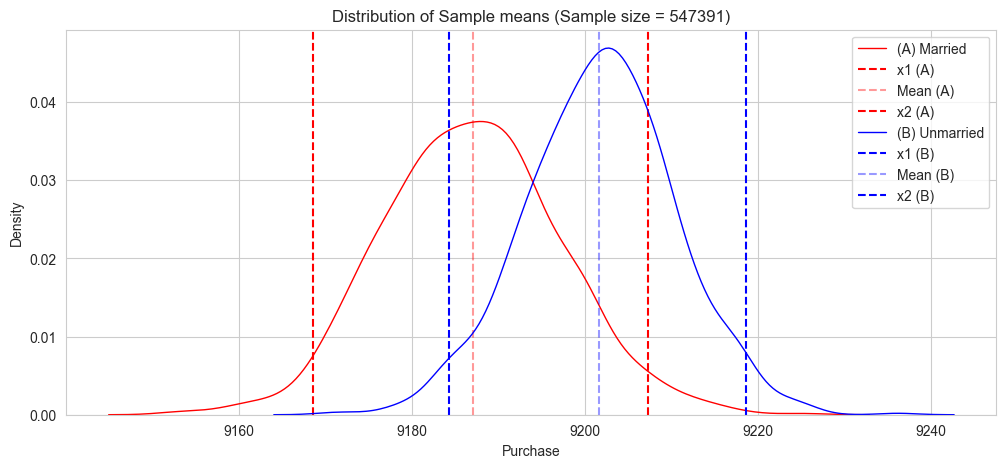

In [78]:
pm_a = np.mean(mar_purchases)
pm_b = np.mean(unm_purchases)
plot_ci(dist_a, pm_a, x1_a, x2_a, "Married", dist_b, pm_b, x1_b, x2_b, "Unmarried", len(wm_df))

#### Sample Size 300

In [79]:
dist_a, x1_a, x2_a = get_confidence_interval(
    sample=mar_purchases,
    sample_size=300,
    confidence_level=0.95,
)
x1_a, x2_a

(8623.54, 9723.0)

In [80]:
dist_b, x1_b, x2_b = get_confidence_interval(
    sample=unm_purchases,
    sample_size=300,
    confidence_level=0.95,
)
x1_b, x2_b

(8662.33, 9778.93)

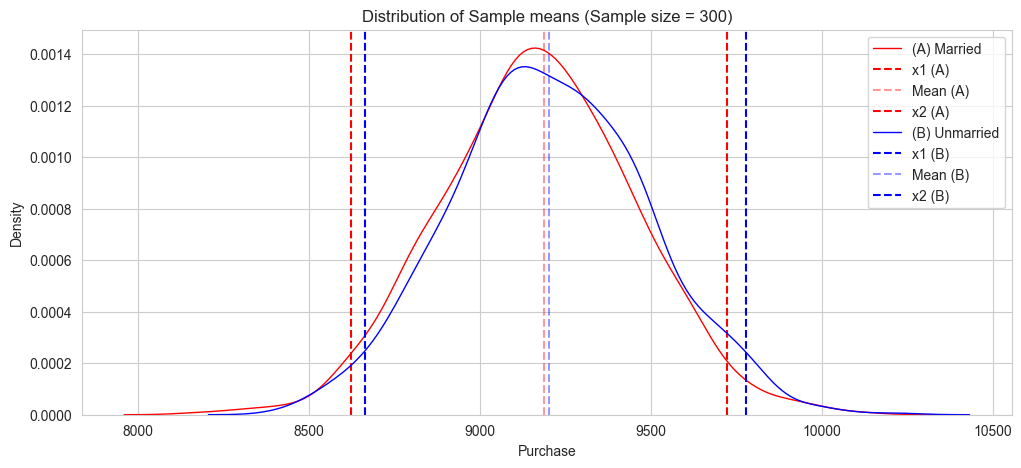

In [81]:
pm_a = np.mean(mar_purchases)
pm_b = np.mean(unm_purchases)
plot_ci(dist_a, pm_a, x1_a, x2_a, "Married", dist_b, pm_b, x1_b, x2_b, "Unmarried", 300)

#### Sample Size 3,000

In [82]:
dist_a, x1_a, x2_a = get_confidence_interval(
    sample=mar_purchases,
    sample_size=3000,
    confidence_level=0.95,
)
x1_a, x2_a

(9007.51, 9343.61)

In [83]:
dist_b, x1_b, x2_b = get_confidence_interval(
    sample=unm_purchases,
    sample_size=3000,
    confidence_level=0.95,
)
x1_b, x2_b

(9023.03, 9366.82)

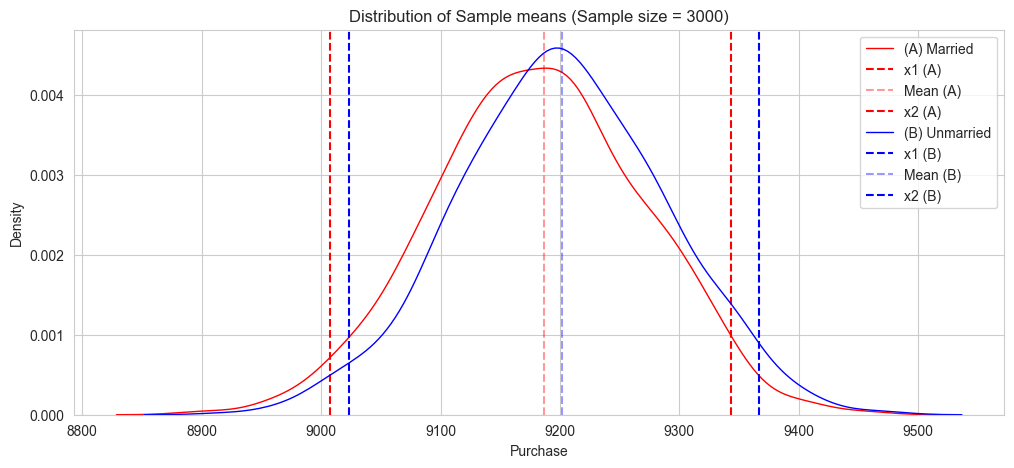

In [84]:
pm_a = np.mean(mar_purchases)
pm_b = np.mean(unm_purchases)
plot_ci(dist_a, pm_a, x1_a, x2_a, "Married", dist_b, pm_b, x1_b, x2_b, "Unmarried", 3000)

#### Sample Size 30,000

In [85]:
dist_a, x1_a, x2_a = get_confidence_interval(
    sample=mar_purchases,
    sample_size=30_000,
    confidence_level=0.95,
)
x1_a, x2_a

(9130.91, 9246.26)

In [86]:
dist_b, x1_b, x2_b = get_confidence_interval(
    sample=unm_purchases,
    sample_size=30_000,
    confidence_level=0.95,
)
x1_b, x2_b

(9143.84, 9259.53)

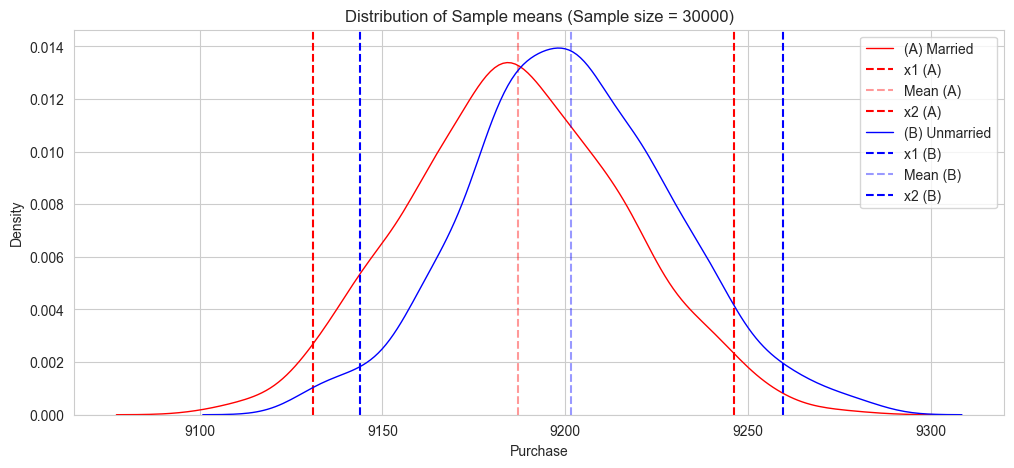

In [87]:
pm_a = np.mean(mar_purchases)
pm_b = np.mean(unm_purchases)
plot_ci(dist_a, pm_a, x1_a, x2_a, "Married", dist_b, pm_b, x1_b, x2_b, "Unmarried", 30000)

### 8.4 CI of `Purchase` for `Age`

In [88]:
def age_group_ci(sample_size: int = 0):
    """
    Function to get confidence interval in each age group.
    """
    dists = []
    x_vals = []
    labels = []

    for grp_name, grp in wm_df.groupby("Age"):
        age_purchases = grp["Purchase"].values
        dist, x1, x2 = get_confidence_interval(
            sample=age_purchases,
            sample_size=sample_size or len(age_purchases),
            confidence_level=0.95,
        )
        dists.append(dist)
        x_vals.append([x1, x2])
        labels.append(grp_name)
        print(f"Group {grp_name}: [{x1}, {x2}]")

    return dists, x_vals, labels

#### Full dataset

In [89]:
dists, x_vals, labels = age_group_ci()

Group 0-17: [8786.52, 8947.16]
Group 18-25: [9094.19, 9152.94]
Group 26-35: [9171.87, 9215.25]
Group 36-45: [9225.72, 9282.65]
Group 46-50: [9084.96, 9171.02]
Group 51-55: [9375.82, 9473.87]
Group 55+: [9152.11, 9282.39]


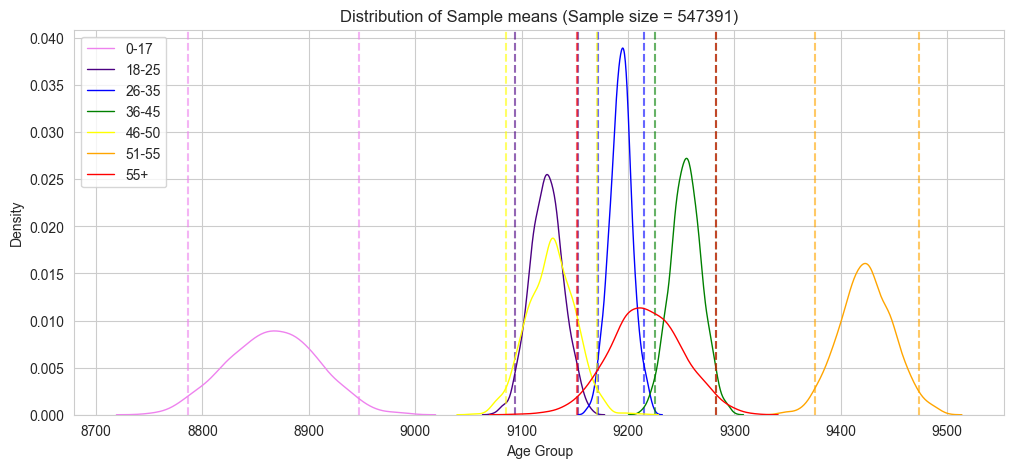

In [90]:
plot_multi_ci(dists, x_vals, labels, len(wm_df))

#### Sample Size 300

In [91]:
dists, x_vals, labels = age_group_ci(300)

Group 0-17: [8281.33, 9470.47]
Group 18-25: [8586.9, 9661.26]
Group 26-35: [8662.56, 9776.33]
Group 36-45: [8661.65, 9785.22]
Group 46-50: [8578.14, 9684.73]
Group 51-55: [8854.2, 9975.23]
Group 55+: [8731.85, 9748.15]


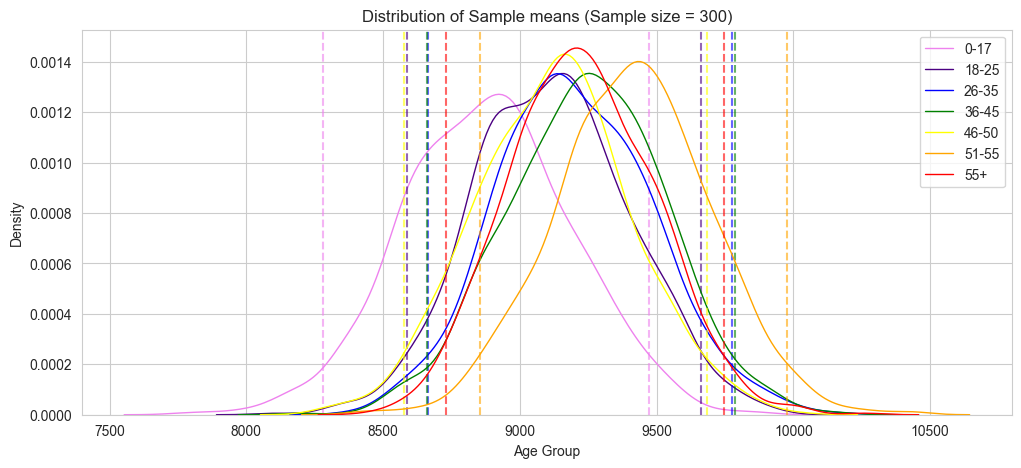

In [92]:
plot_multi_ci(dists, x_vals, labels, 300)

#### Sample Size 3,000

In [93]:
dists, x_vals, labels = age_group_ci(3_000)

Group 0-17: [8684.71, 9054.38]
Group 18-25: [8954.58, 9308.98]
Group 26-35: [9012.67, 9366.7]
Group 36-45: [9065.72, 9422.67]
Group 46-50: [8959.18, 9312.77]
Group 51-55: [9243.61, 9597.0]
Group 55+: [9042.54, 9383.78]


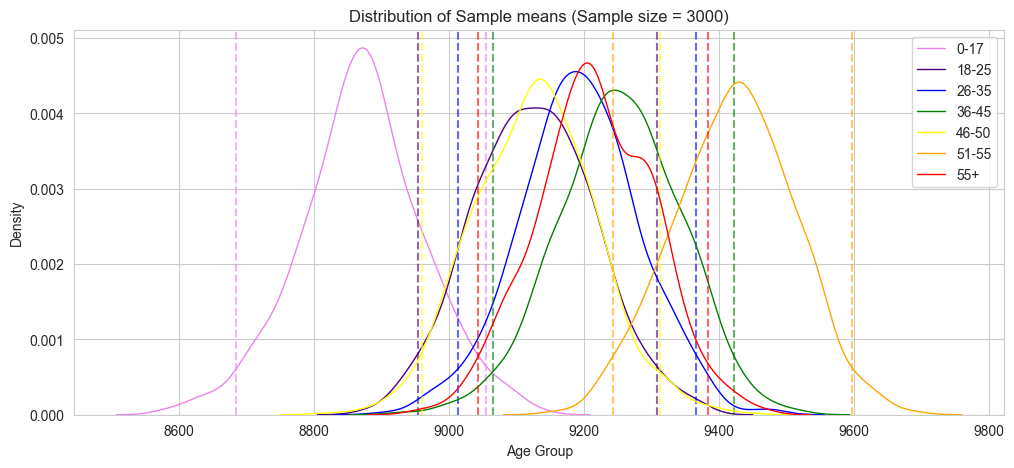

In [94]:
plot_multi_ci(dists, x_vals, labels, 3_000)

#### Sample Size 30,000

In [95]:
dists, x_vals, labels = age_group_ci(30_000)

Group 0-17: [8814.75, 8922.56]
Group 18-25: [9066.88, 9180.95]
Group 26-35: [9134.28, 9249.54]
Group 36-45: [9198.04, 9310.4]
Group 46-50: [9073.52, 9184.16]
Group 51-55: [9368.65, 9477.62]
Group 55+: [9162.76, 9272.06]


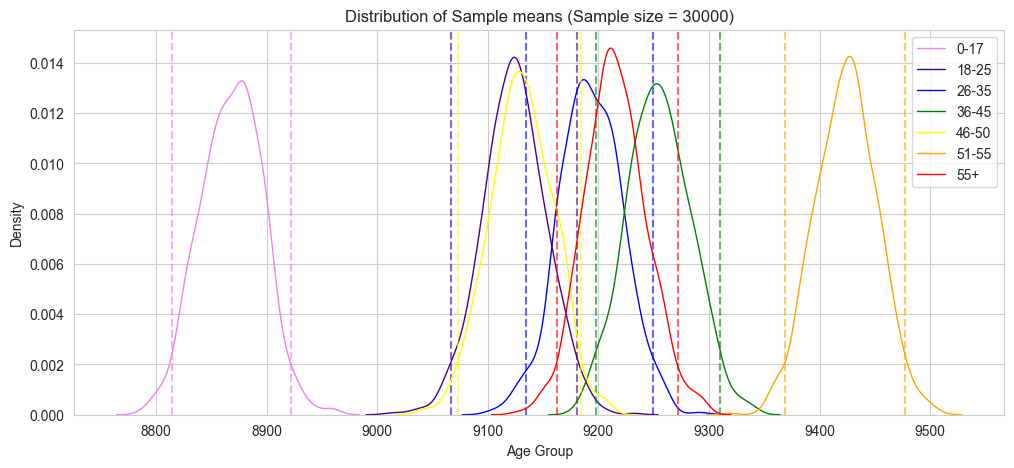

In [96]:
plot_multi_ci(dists, x_vals, labels, 30_000)

## 9 Conclusion

### 9.1 Dataset Insights

1. All Personally Identifiable Information (PII) are masked in the dataset.
1. Dataset is missing purchase date.
1. Dataset contains details of ~500K (550,068) purchases made by customers.
1. Dataset does not contain any missing values.
1. Dataset did not contain any duplicate values.
1. Dataset had 2,677 rows as outliers i.e., 0.49% of the dataset hence they were deleted.
1. Dataset has only one continuos variable namely `Purchase`.
1. Dataset contains purchases made by 5,891 unique customers.
1. Dataset contains purchases of 3,631 unique products.
1. Since there are no duplicate rows for `User_ID` and `Product_ID` combination, all the purchases where done on the same day i.e.,  dataset might be purchases done on Balck Friday of one 

### 9.2 Business Insights

#### 1 Customer Insights

1. 71% of customers are Male and 28% of customers are Female.
1. Top three Age groups of customers.
    1. 35% of customers are between the age 26 and 35
    1. 20% of customers are between the age 36 and 45
    1. 18% of customers are between the age 18 and 25
1. Top thee Occupations of customers:
    1. 13% of customers have occupation type 4
    1. 12% of customers have occupation type 0
    1. 11% of customers have occupation type 7
1. City category ratio:
    1. 53% of customers are from City Category C.
    1. 29% of customers are from City Category B.
    1. 18% of customers are from City Category A.
1. Based on Residence year count:
    1. Around 48% of purchases are done by new customers (who stayed 0 to 1 years in city).
    1. 35% of purchases are done by new customers who stayed more than 1 year in the city.
    1. 20% of purchases are done by new customers who stayed more than 2 year in the city.
1. 42% of customers are Married and 58% of customers are unmarried.

#### 2 Product Insights

1. Top three highest selling products belong to below Product categories:
    1. 27.57% of product purchases belong to Product Category 5
    1. 25.64% of product purchases belong to Product Category 1
    1. 20.81% of product purchases belong to Product Category 8
1. Products in product category 9, 10, 12, 14, 17, 18, 20 has some of the least purchases.
1. Products in product category 5 is most purchased among age group 26-35.
1. Products in product category 1 is most popular among male customers with 21% overall purchases.

### 9.3 General Questions

##### Question #1

What products are different age groups buying?

###### Answer

1. Products in product category 1, 5 and 8 are most purchased among age group 26-35.
2. Products in product category 5 are most purchased among age group 36-45.

##### Question #2

Is there a relationship between age, marital status, and the amount spent?

###### Answer

Visually there is no significant relationship between age, marital status, and the amount spent.

##### Question #3

Are there preferred product categories for different genders?

###### Answer

Yes there are preferred product categories for different genders:

1. 21% of products under product category 1 are purchased by Males.
1. 20% of products under product category 5 are purchased by Males.
1. 15% of products under product category 8 are purchased by Males.
1. 4.5% of products under product category 1 are purchased by Females.
1. 8% of products under product category 5 are purchased by Females.
1. 6% of products under product category 8 are purchased by Females.

##### Question #4

Are women spending more money per transaction than men?

###### Answer

No women are spending less compared to men.

1. Male customers have mean purchase amount of 9725.28 with standard deviation of 1872.39
2. Female customers have mean purchase amount of 8897.34 with standard deviation of 1662.59

### 9.4 Summary on Confidence Interval

Since the purchase distribution is highly skewed its better to calculate Confidence Interval using bootstrapping instead of Central Limit Theorem.

#### 1 `Purchase` vs `Gender`

1. Average Purchase amount of Male customers can lie in between the intervals 8620.39 and 8724.52 with 95% confidence.
2. Average Purchase amount of Female customers can lie in between the intervals 9309.19 and 9425.88 with 95% confidence.

##### Question #1

1. How are average female and male expenses?

###### Answer

1. Median purchase amount of male and female customers are almost equal, even though the percentage of purchases done by females are less compared to Males
2. The IQR of purchase amount of both male and female customers are almost same with males spending slightly higher compared to females. 

##### Question #2

What is the interval within which the average spending of 50 million male and female customers may lie.

###### Answer

The average spending of 50 million male and female customers may lie in the range between 9309.19 and 9425.88

##### Question #3

Is the confidence interval computed using the entire dataset wider for one of the genders?  
Why is this the case?

###### Answer

1. Yes confidence interval computed using the entire dataset is wider for Females compared to Males.
2. confidence interval computed using the entire dataset is taller for Males compared to Females.
3. This indicates that Males have unevenly large samples compared to Females.

##### Question #4

How is the width of the confidence interval affected by the sample size?

###### Answer

Width of the confidence interval is reducing as sample size increases.

##### Question #5

Do the confidence intervals for different sample sizes overlap?

###### Answer

1. Confidence intervals overlaps for small sample size 300
1. Confidence intervals does not overlaps for large sample size 3,000
1. Confidence intervals does not overlaps for large sample size 30,000

##### Question #6

How does the sample size affect the shape of the distributions of the means?

###### Answer

As the sample size increases the distributions of the means width or variance of the distribution is reducing.

#### 2 `Purchase` vs `Marital_Status`

Average Purchase amount of customers Married or Unmarried can lie in between the intervals 9135.84 and 9243.8 with 95% confidence.

##### Question #1

Is the confidence interval computed using the entire dataset wider for one of the Marital_Status?  
Why is this the case?  

###### Answer

1. Yes the confidence interval computed using the entire dataset is wider for married customers.
2. This indicates that the underlying distributions have high variance hence CIs remain wide.

##### Question #2

How is the width of the confidence interval affected by the sample size?

###### Answer

1. Width of the confidence interval is not reducing for different sample size.
2. This happens when the Standard Error is not decreasing with increase in sample size.
3. This indicates that the underlying distributions have high variance.

##### Question #3

Do the confidence intervals for different sample sizes overlap?

###### Answer

Yes confidence intervals for different sample sizes are overlapping.

##### Question #4

How does the sample size affect the shape of the distributions of the means?

###### Answer

1. The distributions of the means is getting closer to normal distribution.
1. Gap between the distribution is reducing as sample size increases.

#### 3 `Purchase` vs `Age`

Average Purchase amount among various age groups with 95% confidence:

1. Group 0-17: [8814.75, 8922.56]
1. Group 18-25: [9066.88, 9180.95]
1. Group 26-35: [9134.28, 9249.54]
1. Group 36-45: [9198.04, 9310.4]
1. Group 46-50: [9073.52, 9184.16]
1. Group 51-55: [9368.65, 9477.62]
1. Group 55+: [9162.76, 9272.06]

##### Question #1

Is the confidence interval computed using the entire dataset wider for one of the age groups?  
Why is this the case?

###### Answer

1. Yes the confidence interval computed using the entire dataset is wider for age groups 0-17 and 51-55.
2. This indicates that the underlying distributions have high variance hence CIs remain wide.

##### Question #2

How is the width of the confidence interval affected by the sample size?

###### Answer

1. Width of the confidence interval is reducing for all the age-groups as sample size increases.
2. This indicates that the true average purchase amount lies within a very specific, small range.

##### Question #3

Do the confidence intervals for different sample sizes overlap?

###### Answer

Sample size: 300

1. Confidence intervals overlaps for all age groups

Sample size: 3,000

1. Confidence intervals does not overlap much for age groups 0-17 and 51-55.
1. Confidence intervals overlaps a lot for remaining age groups: 18-25, 26-35, 36-45, 46-50 and 55+.
1. There is no statistically significant difference among age groups: 18-25, 26-35, 36-45, 46-50 and 55+.

Sample size: 30,00

1. Confidence intervals does not overlap at all for age groups 0-17 and 51-55.
1. Confidence intervals overlaps a lot for remaining age groups: 18-25, 26-35, 36-45, 46-50 and 55+.
1. There is no statistically significant difference among age groups: 18-25, 26-35, 36-45, 46-50 and 55+.

##### Question #4

How does the sample size affect the shape of the distributions of the means?

###### Answer

1. The distributions of the means is getting closer to normal distribution.
1. Distributions of age groups: 18-25, 26-35, 36-45, 46-50 and 55+ remain overlapped as sample size increases.
2. Distributions of age groups: 0-17 and 51-55 moves farther as sample size increases.

### 9.5 Recommendations

1. Low purchase ratio of females in all product categories indicates there aren't any product categories targeting females.
2. Local residents (people staying more than 4+ years) in the cities are not participating in Black Friday sales as much as new residents (less than 3 years). This indicates that there is some saturation in product categories, hence Walmart must introduce newer product categories each year to retain in customer base.
3. Product Category 1, 5, 8 have the highest sales among all age groups hence restock them frequently.
4. Very high gap between the mean-distributions of male and female customers indicate that these groups are very distinct and have their own mean population (average spending).
5. Low gap between the mean-distributions of married and unmarried customers indicate that there isn't difference in a customer average spending whether they are married or unmarried.
6. Point #1 statistically proven by point #4.